## Imports and loading data

In [73]:
import numpy as np 
import scipy 
from scipy.io import loadmat
import h5py
import pandas as pd

Load .mat file and store data into a dictionnary

In [74]:
# The data.mat file should be in the same directory
filepath = 'data.mat'
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

Extract EEG raw data and labels (stimuli)

In [161]:
envelope_raw = arrays['env']
EEG_raw = arrays['eeg']
fs = arrays['fs']
print("EEG raw matrix has shape : {}".format(EEG_raw.shape))
print("envelope raw vector has shape : {}".format(envelope_raw.shape))
print("sampling frequency = {}".format(fs[0]))

EEG raw matrix has shape : (63, 112129)
envelope raw vector has shape : (1, 112129)
sampling frequency = [128.]
-24.534189489164312


## DECODING EEG USING LINEAR MODEL

In [194]:
def individual_lagged_matrix(channel_id):

    #t_max and t_min defined to get 250ms window as defined
    t_min = int(-0.2*fs)  # -200 ms 
    t_max = int(0.05*fs)   # 50 ms 

    #Convert to panda dataframe (easier to shift)
    EEG_raw_df = pd.DataFrame(EEG_raw)

    #Shift index and concatenate to form a single-channel matrix (channel : channel_id)
    tmp = EEG_raw_df.iloc[channel_id]
    tmp_l = tmp

    # Towards t_max 
    for r_shift in range(0, t_max):
        if r_shift ==0:
            tmp = pd.concat([tmp, tmp.shift(1)], axis=1)
        else:
            tmp = pd.concat([tmp, tmp.iloc[:,-1:].shift(1)], axis=1)

    # Towards t_min 
    for l_shift in range(0, t_min, -1):
        if l_shift ==0:
            a = tmp_l.shift(-1)
            tmp_l = pd.concat([a, tmp_l], axis=1)
        else: 
            tmp_l = pd.concat([tmp_l.iloc[:,0].shift(-1), tmp_l], axis=1)
            #print(tmp_l.loc[0])

    # Replace NaN values with 0 (padding)
    tmp_l = tmp_l.fillna(value = 0)
    tmp = tmp.fillna(value = 0)
    
    # Last column from tmp_l and first column of tmp are the same 
    #-> discard last column of tmp_l before concatenating
    tmp_l = tmp_l.iloc[:,:-1]

    # Concatenate left and right part of the matrix
    R_matrix = pd.concat([tmp_l, tmp], axis=1)
    
    return R_matrix.to_numpy()

I should have removed the last column of tmp_l each time (could not do it because of an idx issue) -> one column will be doubled in each individual R_matrix

In [195]:
#Test the function for channel 1
R_matrix = individual_lagged_matrix(1)
#print(R_matrix)
print(R_matrix.shape)

(112129, 32)


Compute the matrix to group windows together together

In [196]:
channel_number = EEG_raw.shape[0]
print(channel_number)
R_matrix_tot = []
# Compute R-matrix for each channel and concatenate them along axis=1 
for channel_id in range(0, channel_number):
    if channel_id == 0:
        R_matrix_tot.append(individual_lagged_matrix(channel_id))
    else: 
        R_matrix_tot.append(individual_lagged_matrix(channel_id))


63


In [198]:
# Now we can access each window of each channel, let's arrange the matrix as required
R_matrix_tot = np.array(R_matrix_tot)
print(R_matrix_tot.shape)

(63, 112129, 32)


In [204]:
# Re-order the matrix so that the R-columns of the same sliding window are together
R_sliding = []
R_matrix_final = []
for window_id in range(0,np.shape(R_matrix_tot)[2]):
    R_sliding = R_matrix_tot[:, :, window_id]
    if window_id == 0:
        R_matrix_final = R_sliding
        print(np.shape(R_matrix_final))
    else: 
        R_matrix_final = np.concatenate((R_matrix_final, R_sliding), axis = 0)

R_matrix_final = R_matrix_final.T
print("R_matrix has shape : {}".format(np.shape(R_matrix_final)))


(63, 112129)
R_matrix has shape : (112129, 2016)


In [205]:
# Add constant term
constant_matrix = np.ones((R_matrix_final.shape[0],channel_number))
#print(constant_matrix)

R_matrix_final = np.concatenate([constant_matrix, R_matrix_final], axis = 1)
print("R_matrix has shape : {}".format(np.shape(R_matrix_final)))
print(R_matrix_final)

R_matrix has shape : (112129, 2079)
[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 5.49990573e-93
  6.79224808e-93 1.32269562e-92]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.27520729e-94
  2.81020447e-94 5.47227318e-94]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 8.23243300e-96
  1.01695829e-95 1.98023343e-95]]


## Dimensionality reduction + 7-fold CV  + Ridge regression

In [223]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
print(R_matrix_final.shape)
print(envelope_raw.T.shape)

(112129, 2079)
(1, 112129)


Dimensionality reduction (PCA) tested because RidgeCV is taking too much time to run

In [225]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(R_matrix_final)
#print(R_matrix_final[:-3,:])
#print(pca.explained_variance_ratio_)

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 4.01043400e-89
  4.95073475e-89 9.64195441e-89]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 2.28318311e-90
  2.81890024e-90 5.48982969e-90]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.18138168e-91
  1.45877797e-91 2.84087427e-91]]
[0.35716671 0.26029564 0.07007756 0.05408029 0.05338964 0.0492827
 0.02469332 0.01314135]


This plot shows that 8 PCs suffice to explain 90% of the variance of the features, we keep 8 ! 

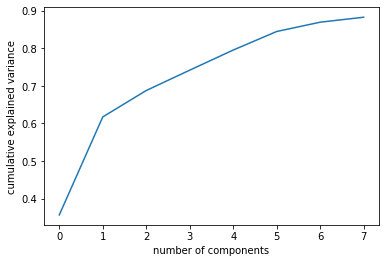

In [226]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [227]:
# Apply PCA transformation to R_matrix
R_reduced = pca.fit_transform(R_matrix_final)
print("Reduced matrix shape : {}".format(R_reduced.shape))
print("Raw envelope data : {}".format(envelope_raw.shape))
print(R_reduced)

Reduced matrix shape : (112129, 8)
Raw envelope data : (112129, 1)
[[-6.99667418e+02 -1.76053026e+02 -5.55691679e+01 ... -8.51164511e+01
  -3.27755785e+01 -2.23132266e+01]
 [-7.05681439e+02 -9.17128792e+01 -7.66882372e+01 ... -9.28049693e+01
  -3.51868099e+01 -1.90217838e+01]
 [-7.03930371e+02  1.07349087e+00 -9.65940777e+01 ... -9.90774925e+01
  -3.73737653e+01 -1.51700248e+01]
 ...
 [-1.07986426e-01 -6.41781718e-02  3.28086190e-02 ...  1.79544067e-03
  -2.64657565e-03  4.30566779e-03]
 [-1.07986426e-01 -6.41781718e-02  3.28086190e-02 ...  1.79544067e-03
  -2.64657565e-03  4.30566779e-03]
 [-1.07986426e-01 -6.41781718e-02  3.28086190e-02 ...  1.79544067e-03
  -2.64657565e-03  4.30566779e-03]]


Proceed to ridge regression and 7-fold CV

In [231]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from numpy import absolute
from numpy import mean
from numpy import std

envelope_raw = envelope_raw.T
scores_tab = []

# define model
alphas=[1e-3, 1e-2, 1e-1, 1, 1.5, 3, 5]
for alpha in alphas:
    model = Ridge(alpha=alpha)
    # define model evaluation method
    #cv_7 = KFold(n_splits=7)
    # evaluate model
    scores = cross_val_score(model, R_reduced, envelope_raw, scoring='r2', cv=7, n_jobs=-1)
    # force scores to be positive
    scores = absolute(scores)
    scores_tab.append(scores)
    print('R^2: %.3f (%.3f)' % (mean(scores), std(scores)))

R^2: 0.003 (0.001)
R^2: 0.003 (0.001)
R^2: 0.003 (0.001)
R^2: 0.003 (0.001)
R^2: 0.003 (0.001)
R^2: 0.003 (0.001)
R^2: 0.003 (0.001)


Boxplot of R^2 across folds for different values of alpha

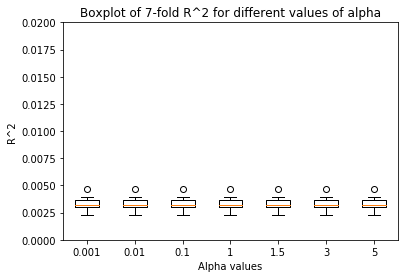

In [232]:
fig = plt.figure()
plt.boxplot(scores_tab, notch = False)
plt.title("Boxplot of 7-fold R^2 for different values of alpha")
plt.xticks([1, 2 ,3, 4, 5, 6, 7], alphas)
plt.xlabel("Alpha values")
plt.ylabel("R^2")
plt.ylim(0,0.02)
plt.show()

The correlation R^2 obtained is low :
- The correlation between the features (EEG data) and the output (speech envelope) might not be linear
- All alpha values are equivalent, which makes me think there might be an issue in the feature matrix that I tried to find without success.  

## DECODING EEG USING DEEP LEARNING

In [241]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Model definition 

In [242]:
def create_model(x_train,y_train,x_val,y_val, cv_scores, nb_units_1, nb_units_2, activation_function_1, activation_function_2, optimizer):
    
    nb_feature = x_train.shape[1]
    nb_unit_output = 1
    
    #Early stopping 
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 10e-4)
 
    #Sequential model
    model = tf.keras.models.Sequential()
    #Specify input shape
    model.add(tf.keras.Input(shape=(nb_feature,)))
    #Two dense layers
    model.add(tf.keras.layers.Dense(nb_units_1, activation = activation_function_1))
    model.add(tf.keras.layers.Dense(nb_units_2, activation = activation_function_2))
    #Output layer
    model.add(tf.keras.layers.Dense(nb_unit_output, activation = 'linear'))
    model.output_shape

    #Compile model 
    model.compile(optimizer = 'adam', loss="mse" )

    model.summary()

    print('compilation ended')
    
    out = model.fit(x_train,y_train, epochs = 50, batch_size = 64, validation_data = (x_val, y_val), callbacks=[callback])
    
    # evaluate the model
    scores = model.evaluate(x_val , y_val , verbose=0)
    print(scores)
    cvscores.append(scores * 100)
    
        
    return out, model, cv_scores, scores

Check size of the feature matrix and label vector 

In [244]:
X = R_matrix_final
y = envelope_raw
print("X shape : {}, y shape {}".format(X.shape, y.shape))


X shape : (112129, 2079), y shape (112129, 1)


Implement 7-fold CV manually and integrate it into the model 

In [245]:
def run_model(X, y, CV_splits, nb_units_1, nb_units_2, activation_function_1, activation_function_2, optimizer):

    # define 7-fold cross validation test harness
    from sklearn.model_selection import KFold
    import matplotlib.pyplot as plt
    kfold = KFold(n_splits= CV_splits, shuffle=True)
    cvscores = []
    
    #Cross-validation
    for train, test in kfold.split(X, y):
        out, model, cv_scores, scores = create_model(X[train], y[train], X[test], y[test], cvscores, 
                                                     nb_units_1, nb_units_2, activation_function_1, 
                                                     activation_function_2, optimizer)
        
        print(out.history)
        print(out)
        
        #Plot validation & train losses to detect potential overfitting
        fig = plt.figure()
        plt.plot(out.history['loss'])
        plt.plot(out.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    print(cv_scores)
    
    return out, model, cv_scores, scores

To analyze the presence of overfitting I found interesting to show the train/validation loss and accuracy curves : here is an example of these curves with random values for hyperparameters. 
What we observe is a convergence of both training and validation loss and a decrease for both. This means that the model is learning from the features over the epochs

In [246]:
# Test with random parameters
out, model, cv_scores, scores = run_model(X, y, CV_splits = 7, nb_units_1 = 1000, nb_units_2 = 1000, activation_function_1 = 'relu',
          activation_function_2 = 'relu', optimizer = 'adam')
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1000)              2080000   
_________________________________________________________________
dense_43 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 1001      
Total params: 3,082,001
Trainable params: 3,082,001
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96110 samples, validate on 16019 samples
Epoch 1/50
 2304/96110 [..............................] - ETA: 3:09 - loss: 465.5746

KeyboardInterrupt: 

Gridsearch analysis to optimize hyperparameters such as : 
- Number of units per layer
- Type of non-linearity to be used in the hidden layers.
- Optimization algorithm

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_46 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96110 samples, validate on 16019 samples
Epoch 1/50
96110/96110 [==============================] - 20s 211us/sample - loss: 1.3584 - val_loss: 0.0806
Epoch 2/50
96110/96110 [==============================] - 8s 88us/sample - loss: 0.0822 - val_loss: 0.8632
Epoch 3/50
96110/96110 [==============================] - 9s 92us/sample - loss: 0.7214 - val

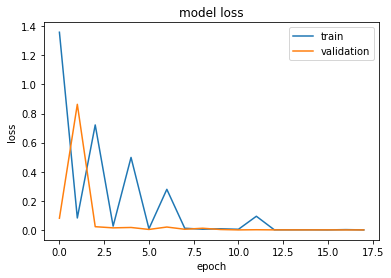

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96110 samples, validate on 16019 samples
Epoch 1/50
96110/96110 [==============================] - 14s 146us/sample - loss: 1.1992 - val_loss: 0.0628
Epoch 2/50
96110/96110 [==============================] - 12s 124us/sample - loss: 1.7524 - val_loss: 2.2738
Epoch 3/50
96110/96110 [==============================] - 14s 142us/sample - loss: 0.2630 -

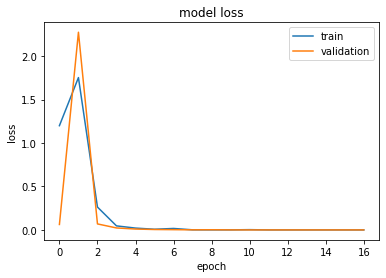

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96110 samples, validate on 16019 samples
Epoch 1/50
96110/96110 [==============================] - 11s 110us/sample - loss: 1.3073 - val_loss: 0.0497
Epoch 2/50
96110/96110 [==============================] - 10s 104us/sample - loss: 0.0695 - val_loss: 0.4525
Epoch 3/50
96110/96110 [==============================] - 10s 103us/sample - loss: 0.6206 -

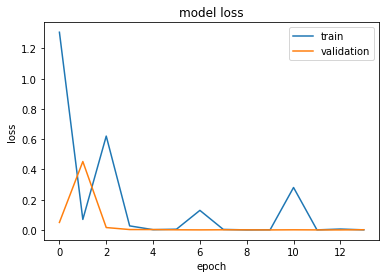

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96111 samples, validate on 16018 samples
Epoch 1/50
96111/96111 [==============================] - 13s 134us/sample - loss: 1.7846 - val_loss: 0.1259
Epoch 2/50
96111/96111 [==============================] - 11s 118us/sample - loss: 0.2282 - val_loss: 0.0444
Epoch 3/50
96111/96111 [==============================] - 15s 154us/sample - loss: 0.1076 -

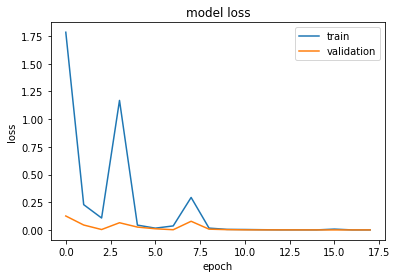

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_58 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96111 samples, validate on 16018 samples
Epoch 1/50
96111/96111 [==============================] - 10s 99us/sample - loss: 1.5368 - val_loss: 0.0599
Epoch 2/50
96111/96111 [==============================] - 9s 91us/sample - loss: 2.0437 - val_loss: 0.2029
Epoch 3/50
96111/96111 [==============================] - 10s 101us/sample - loss: 0.0876 - va

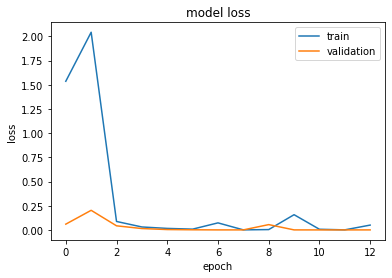

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96111 samples, validate on 16018 samples
Epoch 1/50
96111/96111 [==============================] - 11s 115us/sample - loss: 1.4790 - val_loss: 0.0507
Epoch 2/50
96111/96111 [==============================] - 14s 147us/sample - loss: 0.0354 - val_loss: 0.0204
Epoch 3/50
96111/96111 [==============================] - 9s 94us/sample - loss: 3.3631 - v

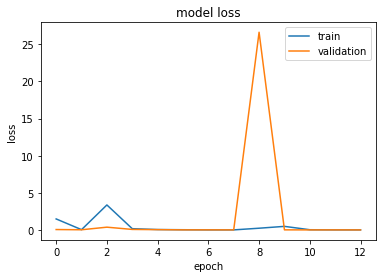

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 100)               208000    
_________________________________________________________________
dense_64 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 101       
Total params: 218,201
Trainable params: 218,201
Non-trainable params: 0
_________________________________________________________________
compilation ended
Train on 96111 samples, validate on 16018 samples
Epoch 1/50
96111/96111 [==============================] - 12s 125us/sample - loss: 1.2489 - val_loss: 0.0469
Epoch 2/50
96111/96111 [==============================] - 13s 140us/sample - loss: 0.9597 - val_loss: 0.0460
Epoch 3/50
96111/96111 [==============================] - 11s 118us/sample - loss: 0.0212 -

KeyboardInterrupt: 

In [247]:
from sklearn.model_selection import GridSearchCV

# Iterate over every parameter's combination 
nb_units_1_tab = [100, 1000]
nb_units_2_tab = [100, 1000]
activation_function_1 = ['relu', 'tanh', 'sigmoid']
activation_function_2 = ['relu', 'tanh', 'sigmoid']
opt_ = ['adam', 'SGD']

for units_1 in nb_units_1_tab:
    for units_2 in nb_units_2_tab:
        for AF_1 in activation_function_1:
            for AF_2 in activation_function_2:
                for opt in opt_:
                    out, model, cv_scores, scores = run_model(X, y, CV_splits = 7, nb_units_1 = units_1, nb_units_2 = units_2, activation_function_1 = AF_1, activation_function_2 = AF_2, optimizer = 'adam')


To improve the model we could : 
- Add dropout layers after each Dense layer to reduce overfitting
- Increase the number of parameters (e.g make the network deeper) to avoid underfitting
